# Jupyter-Notebook zu rpy2

- Dieses Notebook demonstriert das Pythonmodul `rpy2`, um R-Code und R-Pakete in Python zu verwenden.
- _Warum zwischen Python und R wählen, wenn man beides haben kann?_
- Die Statistiksoftware R ist in vielen Bereichen der Wissenschaft verbreitet, und bietet viele Pakete zu Verfahren, die in Python nicht direkt verfügbar sind.


## Welche Module und Pakete werden verwendet?

- NumPy zum Ziehen normalverteilter Stichproben.
- R-Paket `stats` für einen klassischen _t_ Test.
- R-Paket `BF` (BayesFactor) für einen Bayesschen _t_ Test.
  Für weitere Informationen siehe [CRAN Dokumentation](https://cran.r-project.org/web/packages/BayesFactor/index.html).
- R-Paket `effsize` zum Schätzen von Effektstärken.
- R-Paket `pwr` für der Power (Teststärke).

## Kurzbeschreibung rpy2

- RPy2 ist eine Weiterentwicklung eines früheren Projekts RPy-1.x
- Lizenz: GPL Version 2 oder höher.
- Installation: `pip install rpy2`, für mehr Details siehe <https://github.com/rpy2/rpy2#installation>
- Zur Installation der R-Pakete kann Anaconda genutzt werden: `conda install r-pwr r-effsize`
- Achtung; R verwendet viele Namen, die Punkte enthalten, was in Python nicht zulässig ist.
   - Daumenregel: `R`-Funktionen mit Punkt im Namen werden in `rpy2` mit Unterstrich geschrieben, z.B. `R`-Funktion `t.test()` wird in `rpy2` als `t_test()` aufgerufen.
   - Für Funktionen mit Parameternamen die Punkte enthalten kann das "Schlüsselwortargument" `kwargs` so verwendet werden: `**{'key': value}`, siehe Beispiel unten.

## Weiterführende Links

- RPy2 Dokumentation, <https://rpy2.github.io/doc.html>
- R-Views Blogeintrag von Isabella Velásquez, "Calling R From Python With rpy2", <https://rviews.rstudio.com/2022/05/25/calling-r-from-python-with-rpy2/>, mit Beispielen zu R-Paketen `stats`, `lme4`, und `ggplot2`.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
stats = importr('stats')  # für t-Tests
# ez = importr('ez')  # für ezANOVA ("easy ANOVA")
BF = importr('BayesFactor')  # für Bayessche t-Tests
pwr = importr('pwr')
effsize = importr('effsize')

# Welche Versionen sind installiert?
print("Installierte Versionen:")
print(f"rpy2: {rpy2.__version__}")
print(f"R-BF: {BF.__version__}")
print(f"R-effsize: {effsize.__version__}")
print(f"R-pwr: {pwr.__version__}")

# Aktiviere automatisches Konvertieren von numpy-Arrays in R-Arrays
numpy2ri.activate()

Installierte Versionen:
rpy2: 3.3.6
R-BF: 0.9.12-4.2
R-effsize: 0.8.1
R-pwr: 1.3-0


# Simulierte Daten und einfache Statistiken

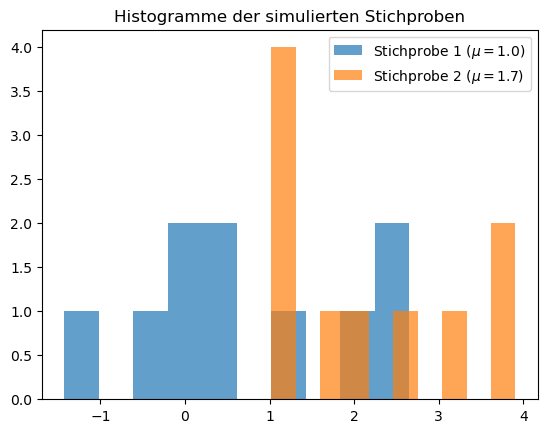

In [8]:
# Setze den Pseudo-Zufallszahlengenerator auf eine replizierbare Position.
np.random.seed(123)

# Ziehe zwei kleine Stichproben aus einer Normalverteilung,
# beide mit derselben Standardabweichung.
N = 10
mu1 = 1.0
mu2 = 1.7
data1 = np.random.normal(loc = mu1, scale = 1, size = N)
data2 = np.random.normal(loc = mu2, scale = 1, size = N)

# Zeige die Daten als Histogramm.
plt.hist(data1, alpha=0.7)
plt.hist(data2, alpha=0.7)
plt.title("Histogramme der simulierten Stichproben")
plt.legend((r"Stichprobe 1 ($\mu = %.1f$)" % mu1,
            r"Stichprobe 2 ($\mu = %.1f$)" % mu2));

In [9]:
# Führe einen klassischen t-Test nach Student durch.
# Der Parameter 'var.equal' ist hier auf True gesetzt, weil wir
# annehmen, dass die Varianzen in beiden Stichproben gleich sind.
# 
# NOTE: Weil die Funktion einen Parameter mit einem Punkt im Namen hat,
#       (var.equal), der in Python unzulässig ist,
#       werden die Parameter hier ausnahmsweise als Dictionary übergeben.
out_r = stats.t_test(**{
                        'x': data1,
                        'y': data2,
                        'alternative': 'two.sided',
                        'paired': False,
                        'var.equal': True})

print("\nAlle Informationen aus dem Ergebnisobjekt:")
print(out_r)

# Optional, gib die Teststatistik und den p-Wert in APA-ähnlichem Format aus.
print("Teststatistik und p-Wert in APA-Format:")
print(f"t({out_r.rx2('parameter')[0]:.1f}) = "
      f"{out_r.rx2('statistic')[0]:.2f}, "
      f"p = {out_r.rx2('p.value')[0]:.3f}")


Alle Informationen aus dem Ergebnisobjekt:

	Two Sample t-test

data:  structure(c(-0.0856306033005612, 1.99734544658359, 1.28297849805199,  and structure(c(1.02111384837795, 1.60529103106311, 3.19138962612429, -0.506294713918092, 0.421399748031464, 2.65143653709715, -1.42667924339307,  and 1.06109800331535, 1.25601804035393, 1.26564872438148, 3.90593008272546, 0.571087371143823, 2.26593625870553, 0.133259597734898), .Dim = 10L) and 3.88678608897379, 2.70405389787888, 2.08618639917486), .Dim = 10L)
t = -2.6753, df = 18, p-value = 0.01544
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -2.6206011 -0.3151343
sample estimates:
mean of x mean of y 
0.7304839 2.1983516 


Teststatistik und p-Wert in APA-Format:
t(18.0) = -2.68, p = 0.015


In [10]:
# Führe einen Bayesschen t-Test durch.
# Bayesfaktoren können im Gegensatz zu p-Werten auch Nullhypothesen unterstützen.
#
# Der Bayesfaktor von ttestBF testet die Nullhypothese, dass der Mittelwert
# (oder die Mittelwertdifferenz) einer Normalverteilung den Wert μ0 hat (Argument mu).
# Der Bayesfaktor vergleicht zwei Hypothesen:
#  H0: Die standardisierte Effektgröße ist 0.
#  H1: Die standardisierte Effektgröße ist nicht 0.
# Für Tests mit einer Stichprobe ist die standardisierte Effektgröße (μ − μ0)/σ;
# für Tests mit zwei Stichproben ist die standardisierte Effektgröße (μ2 − μ1)/σ.

out_r = BF.ttestBF(x = data1,
                   y = data2,
                   mu = 0,  # Nullhypothese: Mittelwertdifferenz ist 0
                   paired = False)

print(out_r)

out_df = BF.as_data_frame_BFBayesFactor(out_r)
print(f"Der BF_10 beträgt {out_df[0][0]:.1f}.")
print(f"Der BF_01 beträgt {1 / out_df[0][0]:.1f}.")

# Nach Jeffreys (1961) gelten Bayesfaktoren größer als ~3, 10 und ~30 als "substantielle",
# "starke" bzw. "sehr starke" Evidenz für eine Hypothese gegenüber einer anderen.
# (Genauer sind die Grenzen durch Zehnerpotenzen definiert; 10^0.5, 10^1 und 10^1.5.)
#
# Ref: Jeffreys, H. (1961). Theory of probability (3rd ed). Oxford University Press.

Bayes factor analysis
--------------
[1] Alt., r=0.707 : 3.797661 ±0%

Against denominator:
  Null, mu1-mu2 = 0 
---
Bayes factor type: BFindepSample, JZS


Der BF_10 beträgt 3.8.
Der BF_01 beträgt 0.3.


# Post-hoc Effektstärke

- Für die Berechnung der Effektstärke wird das R-Paket `effsize` verwendet.

In [11]:
# Berechnen der Effektstärke mit effsize
# Wir berechnen die Effektstärke mit Cohens d.

out_r = effsize.cohen_d(d = data1,
                        f = data2,
                        paired = False)
print(out_r)


Cohen's d

d estimate: -1.196418 (large)
95 percent confidence interval:
     lower      upper 
-2.2165783 -0.1762578 




# Stichprobenplanung mit a-priori Poweranalyse

- Beispielszenario: Nach einer Pilotstudie mit einer bestimmten Effekstärke soll eine Studie mit 80% Power durchgeführt werden.
- Power (Teststärke) ist die Wahrscheinlichkeit, einen Unterschied zu "finden", unter der Annahme, dass er tatsächlich existiert.
   - Zum "Finden" muss ein Test (hier $t$ Test) und ein Signifikanzniveau festgelegt werden (hier $\alpha = 0.05$).

In [12]:
cohens_d = 0.5  # angenommene wahre Effektstärke
power = 0.80  # gewünschte Teststärke
alpha = 0.05  # gewünschtes Signifikanzniveau

out_r = pwr.pwr_t_test(d = cohens_d,
                       power = power,
                       sig_level = alpha,
                       type = "two.sample",  # "paired" or "two.sample"
                       alternative = "greater")  # "two.sided", "less", or "greater"
print(out_r)


     Two-sample t test power calculation 

              n = 50.1508
              d = 0.5
      sig.level = 0.05
          power = 0.8
    alternative = greater

NOTE: n is number in *each* group




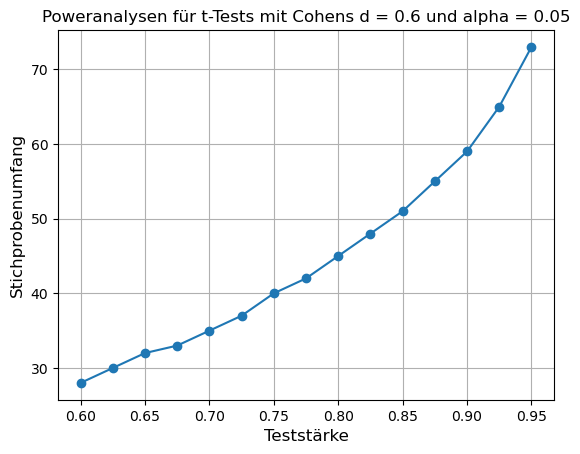

In [108]:
# Wir können auch den benötigten Stichprobenumfang für eine ganze Reihe von
# Teststärken berechnen und diese dann plotten, um einen Eindruck zu bekommen,
# wie viele Probanden wir für eine bestimmte Teststärke benötigen würden.

cohens_d = 0.5  # angenommene wahre Effektstärke
alpha = 0.05  # gewünschtes Signifikanzniveau
# Festlegen der Teststärken, für die wir den Stichprobenumfang berechnen wollen
power_levels = np.linspace(start=0.60, stop= 0.95, num=15)

sample_sizes = np.nan * np.ones(len(power_levels))  # leeres Array mit NaNs

for pp, powerlevel in enumerate(power_levels):
    out_r = pwr.pwr_t_test(d = cohens_d,
                           sig_level = alpha,
                           power = powerlevel,
                           type = "two.sample",
                           alternative = "two.sided")
    sample_sizes[pp] = np.round(out_r.rx2('n'))

plt.plot(power_levels, sample_sizes, 'o-')
plt.xlabel("Teststärke", fontsize=12)
plt.ylabel("Stichprobenumfang", fontsize=12)
plt.title(f"Poweranalysen für t-Tests mit Cohens d = {cohens_d:g} und alpha = {alpha:g}")
plt.grid(True)